In [1]:
pip install visualkeras

In [2]:
# Gerekli kütüphanelerin yüklenmesi

import os
import random
import numpy as np
import sklearn
import cv2
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.applications.vgg16 import preprocess_input, VGG16
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam



import visualkeras
from visualkeras import layered_view
from PIL import Image
from PIL import ImageFont
from PIL import ImageDraw

In [3]:
print(cv2.__version__)
print(sklearn.__version__)
import sys
print(sys.version)

4.8.0
1.2.2
3.10.12 (main, Mar 22 2024, 16:50:05) [GCC 11.4.0]


In [4]:
seed_constant = 27
random.seed(seed_constant)

In [5]:
# Google Drive'ı Colab'e bağlayalım
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
# Veri setimizin dizin yolunu gösterelim

# pic_dir = r'C:\Users\MeNoktaKemal\Desktop\proje1\dataset250' (yerel için)

pic_dir = '/content/drive/My Drive/proje/dataset2'
total_pic_names = os.listdir(pic_dir)
len(total_pic_names)

7083

In [7]:
import tensorflow as tf

# TensorFlow'un GPU'yu tanıyıp tanımadığını kontrol edelim
device_name = tf.test.gpu_device_name()

if device_name != '/device:GPU:0':
    print('GPU bulunamadı')
else:
    print('GPU bulundu: {}'.format(device_name))

# GPU bilgilerini görüntüleme
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

GPU bulundu: /device:GPU:0


[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 3348799078448489519
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 21991653376
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 5562778466903633935
 physical_device_desc: "device: 0, name: NVIDIA L4, pci bus id: 0000:00:03.0, compute capability: 8.9"
 xla_global_id: 416903419]

In [9]:
#total_pic_names  #değişkende saklı tüm resimlerin isimlerini alt alta sırala.
#bu şekilde --- 23_1_2_20170116173110409.jpg.chip.jpg
#print(total_pic_names)  #yan yana sırala

In [8]:
#total_pic_nameste saklı görüntülerin içinden rastgele 6 tanesinin indeksini göster.
'''
random.sample içine tanımladığımız "range(n)" ifadesi 0'dan n-1'e kadar olan sayıları içeren bir dizini temsil eder.
burada n dediğimiz kısım "len(total_pic_names)" olarak belirlendi.
yani 0'dan total_pic_names'in eleman sayısına kadar (24109) bir sayı dizisi oluşturur.
yani bir manada artık, range(len(total_pic_names) sayı dizisi verisetimiz görsellerinin indislerini barındırıyor diyebiliriz.
random.sample işlevi, bu indis dizisinden rastgele 6 tanesini seçer ve random_select değişkenine atar.

'''
random_select = random.sample(range(len(total_pic_names)), 6)
print(random_select)

[5312, 3931, 5745, 2270, 2342, 1608]


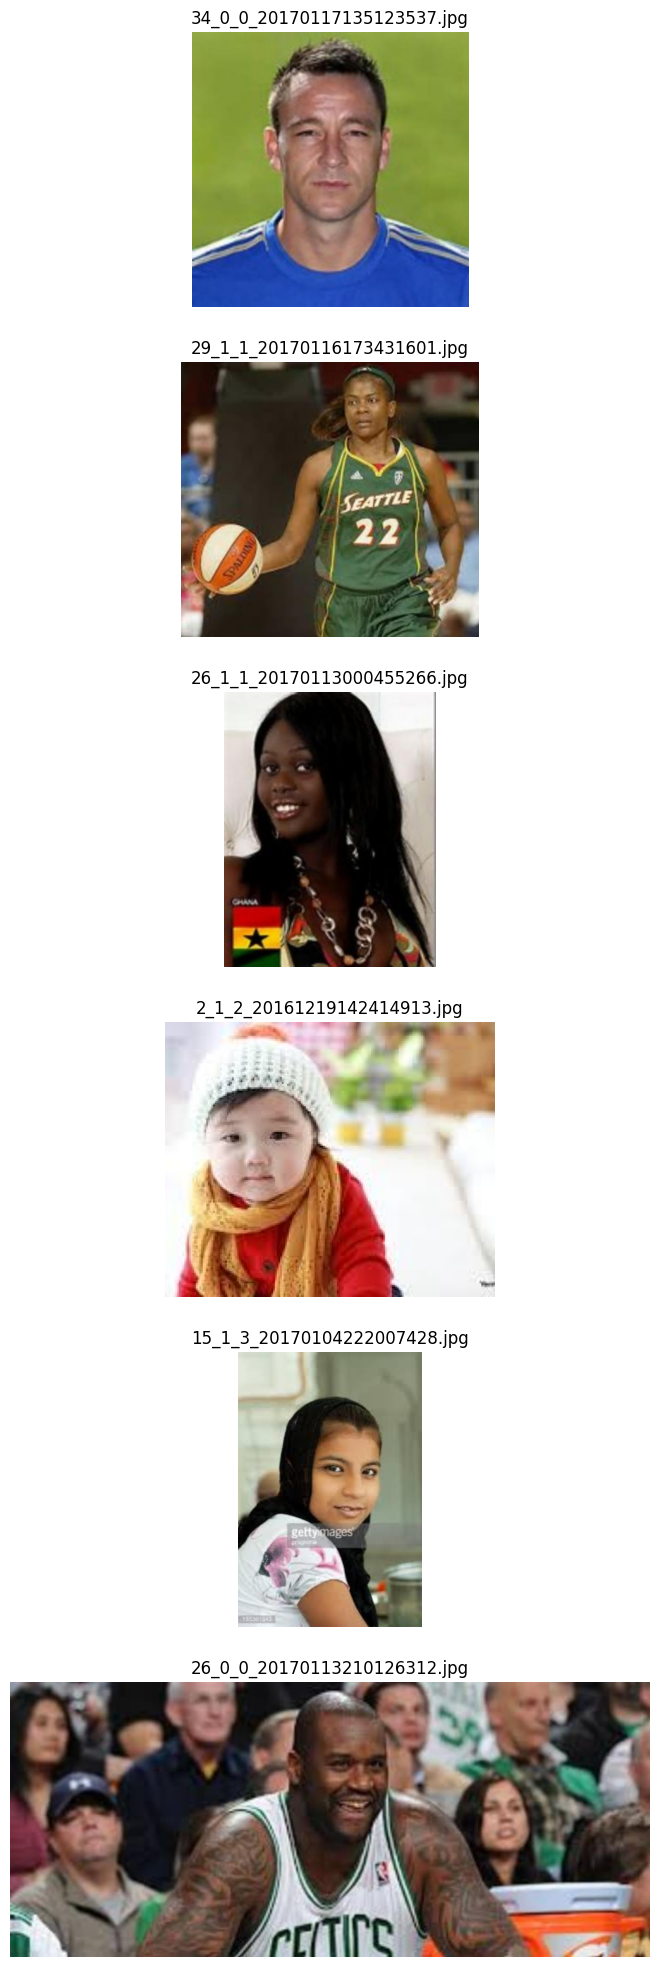

In [9]:
# Veri setimiz içerisinden dosya isimleriyle birlikte 6 rastgele görüntüyü görselleştirelim.
'''
random_index değişkeni, random_select listesindeki elemanların kendilerini temsil eder.
yani random_select = [15739, 18800, 3316, 23088, 6594, 19280] ise,

ilk döngüde; sayaç 1, random_index '15739' olur.
total_pic_namesteki 15739. sıradaki dosya adı alınır ve pic_name değişkenine atanır.
ikinci döngüde; sayaç 2, random_index '18800' olur. 18800. sıradaki dosya adı alınır ve pic_name'e atanır.
pic_name değişkeni her döngüde rastgele seçilmiş random_select dizinindeki 6 görüntünün adını sırayla alır.

'''

# Görüntüleri görelleştirme
plt.figure(figsize = (25,25))
random_select = random.sample(range(len(total_pic_names)), 6)

for counter, random_index in enumerate(random_select, 1):
    pic_name = total_pic_names[random_index]

    # Görselleştirme için dosya yolu oluşturma, resmi okuma ve RGB formatına çevirme
    visualize_pic_path = os.path.join(pic_dir, pic_name)
    pic_bgr = cv2.imread(visualize_pic_path)
    pic_rgb = cv2.cvtColor(pic_bgr, cv2.COLOR_BGR2RGB)

    # Görüntüyü, adıyla birlikte gösterme
    plt.subplot(6, 1, counter)
    plt.imshow(pic_rgb)
    plt.title(pic_name)
    plt.axis('off')

plt.show()



In [10]:
# Verisetindeki Dosya isimi hatalarını bulalım

def check_filename_format(filename):
    parts = filename.split('_')
    # Formatın doğru olduğundan emin olmak için gereken koşullar
    if len(parts) == 4 and parts[3].endswith('.jpg'):
        try:
            age = int(parts[0])
            gender = int(parts[1])
            # Diğer kısımlar da int olabilir, tarih bilgisi veya diğer bilgiler olabilir
            return True
        except ValueError:
            return False
    return False

# Dosya adlarını kontrol edelim
for pic_name in total_pic_names:
    if not check_filename_format(pic_name):
        print(f"Hatalı dosya adı formatı: {pic_name}")

In [11]:
# Veri setini ön işlemeye başlayalım (Preprocessing)

# Verisetimizi içinden rastgele seçilen bir altküme ile sınırlayalım

# Daha önce oluşturduğumuz total_pic_names listesinden bir alt küme seçelim
subset_size = 7000
indices = np.random.choice(len(total_pic_names), subset_size, replace=False)
selected_pic_names = [total_pic_names[i] for i in indices]

pic_height = 224
pic_width = 224

# Görüntü dosyalarını yeniden boyutlandırıp, normalize edecek bir 'image_processing' işlevi tanımlayalım.
def image_processing(pic):
    resized_pic = cv2.resize(pic, (pic_height, pic_width))
    normalized_pic = resized_pic / 255.0
    return normalized_pic


# Etiketleri çıkarmak için işlevler oluşturalım

# Yaş etiketi çıkarmak için fonksiyon tanımlayalım
def age_label_extraction(pic_name):
    age = int(pic_name.split("_")[0])
    return age  #Yaş sınıfı indeksini doğrudan yaş olarak belirledik.

# Cinsiyet etiketi çıkarmak için fonksiyon tanımlayalım
def gender_label_extraction(pic_name):
    try:
        gender = int(pic_name.split("_")[1])
        if gender == 0 or gender == 1:
            return gender
        else:
            return None
    except (IndexError, ValueError) as e:
        print(f"Hata: {e}. Pic name: {pic_name}")
        return None


In [12]:
# Görüntülerin özelliklerini ve etiketlerini oluşturalım

''' sınırlandırılmamış veriseti
def create_dataset():

    features = [] # Özellikler
    age_labels = []  # yaş etiketleri
    gender_labels = [] # cinsiyet etiketleri

    for pic_name in total_pic_names:
        pic_path = os.path.join(pic_dir, pic_name)
        preprocessed_pic = image_processing(pic_path) #preprocessed_pic = normalized_pic
        age_index = age_label_extraction(pic_name)
        gender_index = gender_label_extraction(pic_name)

        features.append(preprocessed_pic)
        age_labels.append(age_index)
        gender_labels.append(gender_index)


    features = np.array(features)
    age_labels = np.array(age_labels)
    gender_labels = np.array(gender_labels)

    return features, age_labels, gender_labels
'''



def create_subset_dataset(selected_pic_names):
    features = []  # Özellikler
    age_labels = []  # Yaş etiketleri
    gender_labels = []  # Cinsiyet etiketleri

    for pic_name in selected_pic_names:

        pic_path = os.path.join(pic_dir, pic_name)
        pic = cv2.imread(pic_path) # Sadece 7000 görüntü okunuyor.
        preprocessed_pic = image_processing(pic)  # preprocessed_pic = normalized_pic
        age_index = age_label_extraction(pic_name)
        gender_index = gender_label_extraction(pic_name)
        if gender_index is not None:  # None olan etiketleri atla
          features.append(preprocessed_pic)
          age_labels.append(age_index)
          gender_labels.append(gender_index)

    features = np.array(features)
    age_labels = np.array(age_labels)
    gender_labels = np.array(gender_labels)

    return features, age_labels, gender_labels


# bu aşamada gerekirse """ONE HOT ENCODING"""" uygulayabiliriz. şimdilik atlayalım.

In [13]:
# Verileri eğitim ve test setine bölelim
##GÜNCELLENİYOR MU KONT##
''' SSSS
# Veri setimizi oluşturalım. /sınırlandırılmamış
features, age_labels, gender_labels = create_dataset()

# Özellikleri ve yaş etiketlerini ayıralım
features_train, features_test, age_labels_train, age_labels_test = train_test_split(
    features, age_labels, test_size=0.1,shuffle=True, random_state=seed_constant)

# Özellikleri ve cinsiyet etiketlerini ayıralım
features_train, features_test, gender_labels_train, gender_labels_test = train_test_split(
    features, gender_labels, test_size=0.1,shuffle=True, random_state=seed_constant)
'''
# 5.000 görüntüyle verisetimizi oluşturalım. /sınırlandırılmış
features, age_labels, gender_labels = create_subset_dataset(selected_pic_names)

# Özellikleri ve yaş etiketlerini ayıralım
#features_train, features_test, age_labels_train, age_labels_test = train_test_split(
#    features, age_labels, test_size=0.1, shuffle=True, random_state=seed_constant)

# Özellikleri ve cinsiyet etiketlerini ayıralım
#features_train, features_test, gender_labels_train, gender_labels_test = train_test_split(
#    features, gender_labels, test_size=0.1, shuffle=True, random_state=seed_constant)

features_train, features_test, age_labels_train, age_labels_test, gender_labels_train, gender_labels_test = train_test_split(
    features, age_labels, gender_labels, test_size=0.1, shuffle=True, random_state=seed_constant)



In [21]:
# VGG16 modelimizi yükleyelim ve yapılandıralım. son katmanı almadık.

# VGG16 modelini yükleme
input_shape = (224, 224, 3)
vgg = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

# Zaten eğitilmiş olan VGG katmanlarını donduralım
for layer in vgg.layers:
    layer.trainable = False

# VGG16 modelinin üstüne kendi fully-connected layers'larınızı ekleyin
x = Flatten()(base_model.output)

# Yoğun bağlı katmanlar ekleyerek, relu aktivasyonu ve L2 düzenlemesi uygulayalım
# Ayrıca, %50 dropout kullanarak ağın genelleştirme yeteneğini artıralım ve overfitting azaltalım.
x = Dense(1250, activation='relu', kernel_regularizer=l2(0.03))(base_model.output)
x = Dropout(0.5)(x)

x = Dense(1000, activation='relu', kernel_regularizer=l2(0.03))(x)
x = Dropout(0.5)(x)

x = Dense(512, activation='relu', kernel_regularizer=l2(0.03))(x)
x = Dropout(0.5)(x)

# Yaş tahmini için ek dense katman
x_age = Dense(256, activation='relu', kernel_regularizer=l2(0.03))(x)
x_age = Dropout(0.5)(x_age)

# Yaş tahmini için regresyon katmanı oluşturalım
age_prediction = Dense(1, activation='linear', name='age_prediction')(x_age)

# Cinsiyet tespiti için sınıflandırma katmanı oluşturalım
gender_prediction = Dense(1, activation='sigmoid', name='gender_prediction')(x)

# Modelimizi tanımlayalım
model = Model(inputs=base_model.input, outputs=[age_prediction, gender_prediction])

# Modelimizin özetini yazdıralım
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 224, 224, 64)         1792      ['input_4[0][0]']             
                                                                                                  
 block1_conv2 (Conv2D)       (None, 224, 224, 64)         36928     ['block1_conv1[0][0]']        
                                                                                                  
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)         0         ['block1_conv2[0][0]']        
                                                                                            

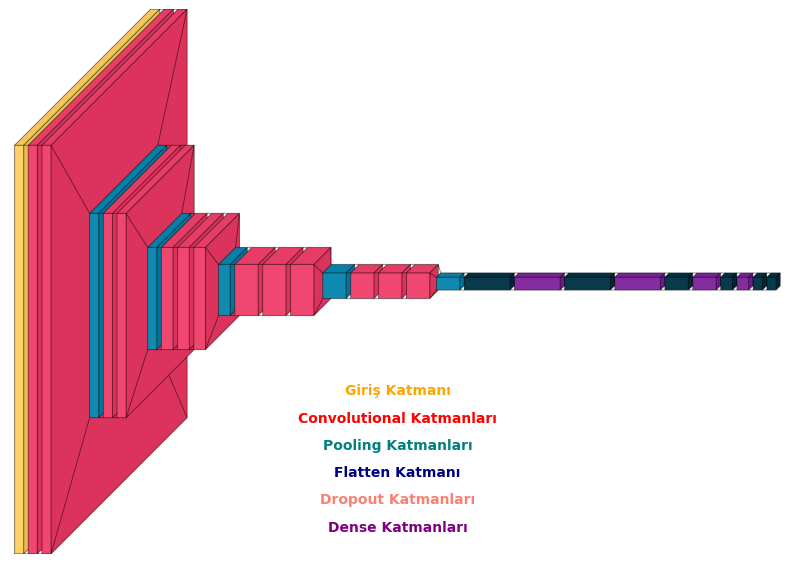

In [15]:
# Modelimizi görselleştirelim

visualkeras.layered_view(model, to_file='model.png')
visualmodel = plt.imread('model.png')
plt.figure(figsize=(10, 10))
plt.imshow(visualmodel)
plt.axis('off')

plt.text(0.5, 0.05, 'Dense Katmanları', horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes, color='purple', fontweight='bold')
plt.text(0.5, 0.15, 'Flatten Katmanı', horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes, color='navy', fontweight='bold')
plt.text(0.5, 0.10, 'Dropout Katmanları', horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes, color='salmon', fontweight='bold')
plt.text(0.5, 0.20, 'Pooling Katmanları', horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes, color='teal', fontweight='bold')
plt.text(0.5, 0.25, 'Convolutional Katmanları', horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes, color='red', fontweight='bold')
plt.text(0.5, 0.30, 'Giriş Katmanı', horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes, color='orange', fontweight='bold')

plt.show()


In [22]:
# Modeli eğitelim

'''# EarlyStopping oluşturalım
early_stopper = EarlyStopping(monitor='val_loss', patience=5, mode='min', restore_best_weights=True)

# CheckPoint oluşturalım
filepath = "BestWeights_trial.keras"
weight_saver = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, mode='max', save_best_only=True)'''

# Yeni early ve checkpoint deneme
# EarlyStopping oluşturalım
early_stopper = EarlyStopping(
    monitor='val_age_prediction_mae',
    patience=20,
    mode='min',
    restore_best_weights=True)

# CheckPoint oluşturalım
filepath = "BestWeights_trial.keras"
weight_saver = ModelCheckpoint(filepath,
                               monitor='val_gender_prediction_accuracy',
                               verbose=1,
                               mode='max',
                               save_best_only=True)


# callbacks
callbacks_list = [early_stopper, weight_saver]

# Modeli derleyelim
# Modelimiz birden fazla çıktı ürettiği için (age ve gender) loss ve metrics dictionary(sözlük) olarak belirtilmiştir.
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss={'age_prediction': 'mean_absolute_error',
          'gender_prediction': 'binary_crossentropy'},
    metrics={'age_prediction': 'mae',
             'gender_prediction': 'accuracy'})

# Modelimizi eğitelim
history = model.fit(
    features_train, {'age_prediction': age_labels_train, 'gender_prediction': gender_labels_train},
    epochs = 50,
    batch_size = 96,
    validation_split= 0.1,
    callbacks = callbacks_list)



Epoch 1/50
60/60 [==============================] - ETA: 0s - loss: 129.8997 - age_prediction_loss: 18.5962 - gender_prediction_loss: 1.4980 - age_prediction_mae: 18.5962 - gender_prediction_accuracy: 0.5120
Epoch 1: val_gender_prediction_accuracy improved from -inf to 0.69841, saving model to BestWeights_trial.keras
60/60 [==============================] - 50s 530ms/step - loss: 129.8997 - age_prediction_loss: 18.5962 - gender_prediction_loss: 1.4980 - age_prediction_mae: 18.5962 - gender_prediction_accuracy: 0.5120 - val_loss: 102.3373 - val_age_prediction_loss: 13.5905 - val_gender_prediction_loss: 0.6002 - val_age_prediction_mae: 13.5905 - val_gender_prediction_accuracy: 0.6984
Epoch 2/50
59/60 [============================>.] - ETA: 0s - loss: 91.5843 - age_prediction_loss: 14.7717 - gender_prediction_loss: 1.0914 - age_prediction_mae: 14.7717 - gender_prediction_accuracy: 0.5484
Epoch 2: val_gender_prediction_accuracy improved from 0.69841 to 0.73968, saving model to BestWeights_

In [23]:
# En iyi doğrulama doğruluğuna sahip modelin ağırlıklarını yükleyelim
model.load_weights("BestWeights_trial.keras")

In [24]:
# Modeli test verisi üzerinde değerlendirelim

model_evaluation_history = model.evaluate(features_test, {'age_prediction': age_labels_test, 'gender_prediction': gender_labels_test})

22/22 [==============================] - 11s 305ms/step - loss: 15.5419 - age_prediction_loss: 9.6929 - gender_prediction_loss: 0.3878 - age_prediction_mae: 9.6929 - gender_prediction_accuracy: 0.8257


In [25]:
# Modelimizi kaydedelim
model.save("best_val_acc_model.keras")

In [26]:
print(history.history.keys())


dict_keys(['loss', 'age_prediction_loss', 'gender_prediction_loss', 'age_prediction_mae', 'gender_prediction_accuracy', 'val_loss', 'val_age_prediction_loss', 'val_gender_prediction_loss', 'val_age_prediction_mae', 'val_gender_prediction_accuracy'])


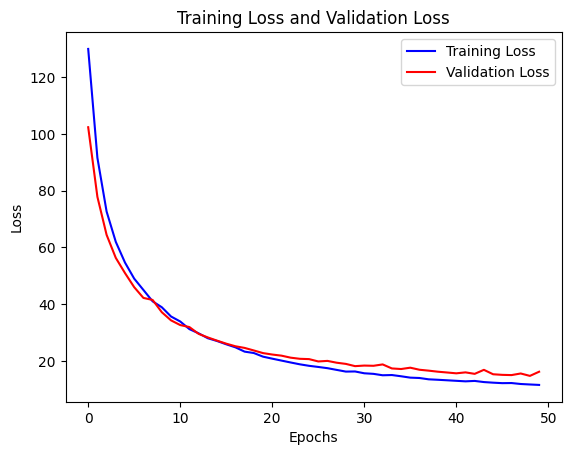

In [27]:
# Eğitim ve Doğrulama Kaybı Grafiği Oluşturalım (modelin genel performansını inceleyelim)

epochs = range(len(history.history['loss']))

plt.plot(epochs, history.history['loss'], 'blue', label='Training Loss')
plt.plot(epochs, history.history['val_loss'], 'red', label='Validation Loss')

plt.title('Training Loss and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


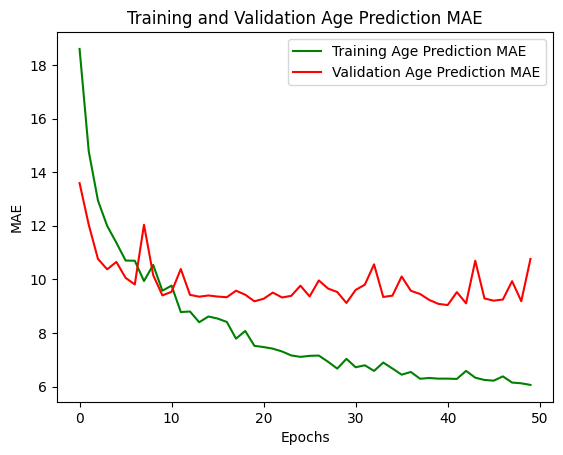

In [28]:
# Yaş Tahmin MAE Grafiği Oluşturalım (Yaş tahmini doğruluğu grafiği) - düşük olmalı

epochs = range(len(history.history['age_prediction_mae']))

plt.plot(epochs, history.history['age_prediction_mae'], 'green', label='Training Age Prediction MAE')
plt.plot(epochs, history.history['val_age_prediction_mae'], 'red', label='Validation Age Prediction MAE')

plt.title('Training and Validation Age Prediction MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()

plt.show()

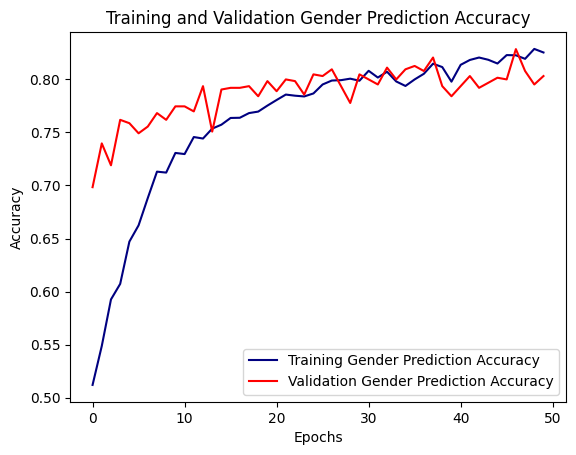

In [29]:
# Cinsiyet Tahmini Doğruluğu Grafiği OLuşturalım

epochs = range(len(history.history["gender_prediction_accuracy"]))

plt.plot(epochs, history.history["gender_prediction_accuracy"], 'navy', label="Training Gender Prediction Accuracy")
plt.plot(epochs, history.history["val_gender_prediction_accuracy"], 'red', label="Validation Gender Prediction Accuracy")

plt.title("Training and Validation Gender Prediction Accuracy")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [30]:
# Modelimizi yeni Görüntü verileriyle test edelim

'''
    def detect_age_gender(pic_path):
    try:
        pic = cv2.imread(pic_path)
        if pic is None:
            print(f"Görüntü okunamadı: {pic_path}")
            return None, None
        # Görüntüyü ön işleme tabi tutalım
        preprocessed_pic = image_processing(pic)
        reshaped_pic = np.reshape(preprocessed_pic, (1, 224, 224, 3))
        print("Picture shape:", picture.shape)
        print("Picture dtype:", picture.dtype)



        # Modelden tahminler alalım
        predictions = model.predict(normalized_picture)

        age_prediction = predictions[0][0]
        gender_prediction = predictions[1][0]


        model.predict fonksiyonu 2 tahmin döndürecektir; yaş ve cinsiyet.

        age_prediction için açıklama:
        1. predictions[0]: Modelin birinci çıkışını temsil eder. Bu çıkış, yaş tahminini yapar.
        2. predictions[0][0]: predictions[0]'ın ilk elemanıdır ve bu, yaş tahmininin doğrudan değeridir.
           Model, yaş tahminini 'lineer aktivasyon fonksiyonu' kullanarak doğrudan bir sayısal değer olarak döndürür.
           Bu değer doğrudan 'age_prediction' değişkeninde saklanır.

        gender_prediction için açıklama:
        1. predictions[1]: Modelin ikinci çıkışını temsil eder. Bu çıkış, cinsiyet tahminini yapar.
        2. predictions[1][0]: predictions[1]'in ilk elemanıdır ve bu, cinsiyet tahmininin olasılık değeridir.
           Model, cinsiyet tahminini 'sigmoid aktivasyon fonksiyonu' kullanarak [0, 1] aralığında bir olasılık değeri olarak döndürür.
           Bu değer, '0.5' eşik değerinden büyükse "Erkek", küçükse "Kadın" olarak sınıflandırılır ve 'gender' değişkenine atanır.


        # Cinsiyet tahminini belirleyelim
        if gender_prediction > 0.5:
            gender = "Erkek"
        else:
            gender = "Kadin"

        return age_prediction, gender

    except Exception as e:
        print(f"Hata: {e}")
        return None, None
'''


def detect_age_gender(pic_path):
    try:
        pic = cv2.imread(pic_path)
        if pic is None:
            print(f"Görüntü okunamadı: {pic_path}")
            return None, None

        preprocessed_pic = image_processing(pic)
        reshaped_pic = np.reshape(preprocessed_pic, (1, 224, 224, 3))

        # Modelden tahminler alalım
        predictions = model.predict(reshaped_pic)

        age_prediction = predictions[0][0]
        gender_prediction = predictions[1][0]

        if gender_prediction < 0.5:
            gender = "Erkek"
        else:
            gender = "Kadin"

        return age_prediction, gender

    except Exception as e:
        print(f"Hata: {e}")
        return None, None


In [31]:
# Yeni veri seti yolumuzu belirleyelim
newset_dir ='/content/drive/My Drive/proje/datateni'
#newset_dir = r'C:\Users\MeNoktaKemal\Desktop\proje1\newdataset' (yerel)
newset_pic_names = os.listdir(newset_dir)

for counter, newset_pic_name in enumerate(newset_pic_names):
    # Seçilen görüntünün dosya yolu
    newpic_path = os.path.join(newset_dir, newset_pic_name)
    print(f"İşleniyor: {newpic_path}")

    # Tahminleme yapalım
    predicted_age, predicted_gender = detect_age_gender(newpic_path)

    if predicted_age is None or predicted_gender is None:
        print(f"Tahmin yapılamadı: {newpic_path}")
        continue  # Tahmin yapılamadıysa bu resmi atla


    # Görüntüyü okuyalım
    newpic_bgr = cv2.imread(newpic_path)
    if newpic_bgr is None:
        print(f"Görüntü okunamadı: {newpic_path}")
    else:
        # Görüntü başarıyla okundu, şimdi resize işlemi yapabilirsiniz
        newpic_rgb = cv2.cvtColor(newpic_bgr, cv2.COLOR_BGR2RGB)

        # Tahmin edilen yaş ve cinsiyeti görüntünün üstüne yazalım
        cv2.putText(newpic_rgb, f"Yas: {int(predicted_age[0])}", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 0, 255), 3)
        cv2.putText(newpic_rgb, f"Cinsiyet: {predicted_gender}", (10, 60), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 0, 255), 3)

        # Seçilen görüntüyü gösterelim
        plt.imshow(newpic_rgb)
        plt.axis('off')
        plt.show()

Output hidden; open in https://colab.research.google.com to view.